In [1]:
# Libraries
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

`Attribute exploration (ground truth labels for the images)`

Every image has annotations with ground truth values for the different attributes (312):

* A 312 vector with values ranging from 0-1 -> I have binarized them for clarity
*  Each of the values in the vector correspond to a defined attribute which I have also printed


In [3]:
# Load the attribute names from the attributes.txt file
with open('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/attributes.txt', 'r') as f:
    attribute_names = [line.strip() for line in f.readlines()]

# Load the class attribute labels from the class_attribute_labels_continuous.txt file
class_attribute_labels = np.loadtxt('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/attributes/class_attribute_labels_continuous.txt')

# Load the class labels for the images
with open('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/image_class_labels.txt', 'r') as f:
    class_labels = np.loadtxt(f, dtype=int, usecols=[1])

# Get the attribute vector for the first image (index 0)
image_index = 508
attribute_vector = class_attribute_labels[class_labels[image_index] - 1]

# Binarize the attribute vector
binary_vector = (attribute_vector > 0.5).astype(int)

# Get the top 5 attributes with the highest values
top_indices = np.argsort(attribute_vector)[::-1][:10]
top_attributes = [attribute_names[i] for i in top_indices]

# Print the results
print('Attribute values:', binary_vector)
print('Top 10 attributes:', top_attributes)




Attribute values: [0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1
 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1
 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1
 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1]
Top 10 attributes: ['179 has_under_tail_color::black', '146 has_eye_color::black', '51 has_underparts_color::black', '70 has_back_color::black', '91 has_upper_tail_color::black', '260 has_primary_color::black', '132 has_throat_color::black', '164 has_forehead_color::black', '305 has_crown_color::black', '117 has_breast_color::black']


* There is a mismatch because the image inside each folder has a capital letter instead of having the same name of the folder. Idk how to fix it.
* I need to know the exact names of the images used in the saliency maps to extract the correct ground truth attributes. 

In [4]:
# Load the image file names
image_folder ='/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images/'
image_files = os.listdir(image_folder)

image_index = 0
species_folder = str(class_labels[image_index]).zfill(3) + '.' + class_names[image_index]
image_path = '/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images/{}/{}_{}.jpg'.format(species_folder, species_folder, str(image_index + 1).zfill(4))
image = Image.open(image_path)

# Display the image and print the results
plt.imshow(image)
plt.axis('off')
plt.title('Image with ID {}'.format(image_index + 1))
plt.show()


NameError: name 'class_names' is not defined

# Quantitative Validation strategy

## Accuracy of explanations provided by each model

### Saliency map vs bounding boxes 

To calculate the accuracy using the saliency map and the ground truth explanation (bounding box), we can use the following steps:

To calculate the IoU, you can first convert the saliency map to a binary mask by thresholding it at a certain level (e.g., 0.5). Then, you can compute the intersection between the binary mask and the bounding box by multiplying them element-wise and summing the result. Similarly, you can compute the union between them by summing the number of pixels in both the binary mask and the bounding box and subtracting the intersection. Finally, you can calculate the IoU as the ratio of the intersection to the union.

The higher the IoU value, the better the saliency map aligns with the ground truth bounding box. This measure provides a way to evaluate the quality of saliency maps and how well they capture the object of interest in the image.

> Test images to be plotted to asses the quality of the explanations
 
 * `/images/010.Red_winged_Blackbird/Red_Winged_Blackbird_0053_4072.jpg'`
 * `/images/177.Prothonotary_Warbler/Prothonotary_Warbler_0081_173510.jpg`
 * `/images/139.Scarlet_Tanager/Scarlet_Tanager_0043_138236.jpg`
 * `/images/139.Scarlet_Tanager/Scarlet_Tanager_0009_138076.jpg`
 * `/images/161.Blue_winged_Warbler/Blue_Winged_Warbler_0004_162005.jpg`
 * `/images/007.Parakeet_Auklet/Parakeet_Auklet_0020_795947.jpg`

In [87]:
# Path to saliency map
PATH_saliency_maps = 'data/saliency_maps.npy'
PATH_gradcam_maps = 'data/grad_cam.npy'

In [88]:
# Path to ground truth bounding boxes 
ground_truth_bb = pd.read_csv('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/bounding_boxes.txt', header=None)
df= ground_truth_bb.rename(columns = { 0 : 'bbox_info'})

# Split bbox column into separate columns
df[["index", "x", "y", "width", "heigth"]] = df["bbox_info"].str.split(" ", expand=True)

# Convert values to appropriate data types
df["index"] = df["index"].astype(int)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["width"] = df["width"].astype(float)
df["heigth"] = df["heigth"].astype(float)

df.head()
df

bbox_info  index      x      y  width  heigth
0            1 60.0 27.0 325.0 304.0      1   60.0   27.0  325.0   304.0
1           2 139.0 30.0 153.0 264.0      2  139.0   30.0  153.0   264.0
2           3 14.0 112.0 388.0 186.0      3   14.0  112.0  388.0   186.0
3           4 112.0 90.0 255.0 242.0      4  112.0   90.0  255.0   242.0
4            5 70.0 50.0 134.0 303.0      5   70.0   50.0  134.0   303.0
...                              ...    ...    ...    ...    ...     ...
11783    11784 89.0 95.0 354.0 250.0  11784   89.0   95.0  354.0   250.0
11784   11785 157.0 62.0 184.0 219.0  11785  157.0   62.0  184.0   219.0
11785  11786 190.0 102.0 198.0 202.0  11786  190.0  102.0  198.0   202.0
11786     11787 3.0 20.0 408.0 307.0  11787    3.0   20.0  408.0   307.0
11787   11788 20.0 113.0 177.0 263.0  11788   20.0  113.0  177.0   263.0

[11788 rows x 6 columns]

In [89]:
# Define the path to the images.txt file
images_txt_path = '/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images.txt'


# Extract the image IDs from the lines
image_txt = pd.read_csv(images_txt_path,sep=' ', names=['id', 'filename'],header=None)
image_txt

# Define the image directory
image_dir = '/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images/'

# Define the paths to the test images
test_images_paths= ['010.Red_winged_Blackbird/Red_Winged_Blackbird_0053_4072.jpg',
                    '177.Prothonotary_Warbler/Prothonotary_Warbler_0081_173510.jpg',
                    '139.Scarlet_Tanager/Scarlet_Tanager_0043_138236.jpg',
                    '139.Scarlet_Tanager/Scarlet_Tanager_0009_138076.jpg',
                    '161.Blue_winged_Warbler/Blue_Winged_Warbler_0004_162005.jpg',
                    '007.Parakeet_Auklet/Parakeet_Auklet_0020_795947.jpg'               
                   ]

# Create a list mapping image IDs to their file paths
image_id_map = [image_txt[image_txt['filename'] == i]['id'].values[0] for i in test_images_paths]

# Create a new dataframe with the test image paths and IDs
test_image_df = pd.DataFrame({'id': image_id_map, 'file_path': test_images_paths})

# Save the full path for future plotting of the image
test_image_df['full_path'] = [image_dir + i for i in test_images_paths]

# Get the corresponding information from `df` for each test image
test_image_df['info'] = [list(df.loc[df['index'] == id, ['x', 'y', 'width', 'heigth']].values[0]) for id in test_image_df['id']]

# Calculate the bounding box coordinates for the test images
test_image_df['bounding_box'] = test_image_df['info'].apply(lambda info: [info[0], info[1], info[0]+info[2], info[1]+info[3]])

test_image_df

id                                          file_path  \
0    508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
1  10422  177.Prothonotary_Warbler/Prothonotary_Warbler_...   
2   8159  139.Scarlet_Tanager/Scarlet_Tanager_0043_13823...   
3   8139  139.Scarlet_Tanager/Scarlet_Tanager_0009_13807...   
4   9455  161.Blue_winged_Warbler/Blue_Winged_Warbler_00...   
5    340  007.Parakeet_Auklet/Parakeet_Auklet_0020_79594...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   
1  /Users/lucialarraona/Desktop/responsibleai/Con...   
2  /Users/lucialarraona/Desktop/responsibleai/Con...   
3  /Users/lucialarraona/Desktop/responsibleai/Con...   
4  /Users/lucialarraona/Desktop/responsibleai/Con...   
5  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]  
1   [25.0, 50.0, 374.0, 222.0]   [25.0, 50.0, 399.0, 272.0]  
2   [99.0, 82.0, 318.0, 233.0]   [99.0, 82.0, 417.0, 315.0]  
3  [137.0, 76.0, 202.0, 163.0]  [137.0, 76.0, 339.0, 239.0]  
4  [34.0, 116.0, 311.0, 241.0]  [34.0, 116.0, 345.0, 357.0]  
5   [88.0, 96.0, 222.0, 385.0]   [88.0, 96.0, 310.0, 481.0]

> Transform images as they are in the training and testing and save them in a new folder

In [90]:
def transform_images_and_save(image_paths, crop_size=299, output_dir='cropped_images'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the PyTorch transform
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
    ])
    
    cropped_image_paths = []
    
    for image_path in image_paths:
        # Load the image
        image_np = cv2.imread(image_path)
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Apply the transform to the image and get the cropped image
        cropped_image = transform(image)

        # Save the cropped image with full absolute path
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        output_path = os.path.abspath(output_path)
        cropped_image.save(output_path)
        cropped_image_paths.append(output_path)
        
    # Store the full path of the cropped image in a new column of the test_image_df
    output_path_column_name = 'cropped_image_path'
    test_image_df[output_path_column_name] = cropped_image_paths


transform_images_and_save(test_image_df['full_path'].tolist())

In [91]:
test_image_df

id                                          file_path  \
0    508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
1  10422  177.Prothonotary_Warbler/Prothonotary_Warbler_...   
2   8159  139.Scarlet_Tanager/Scarlet_Tanager_0043_13823...   
3   8139  139.Scarlet_Tanager/Scarlet_Tanager_0009_13807...   
4   9455  161.Blue_winged_Warbler/Blue_Winged_Warbler_00...   
5    340  007.Parakeet_Auklet/Parakeet_Auklet_0020_79594...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   
1  /Users/lucialarraona/Desktop/responsibleai/Con...   
2  /Users/lucialarraona/Desktop/responsibleai/Con...   
3  /Users/lucialarraona/Desktop/responsibleai/Con...   
4  /Users/lucialarraona/Desktop/responsibleai/Con...   
5  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   
1   [25.0, 50.0, 374.0, 222.0]   [25.0, 50.0, 399.0, 272.0]   
2   [99.0, 82.0, 318.0, 233.0]   [99.0, 82.0, 417.0, 315.0]   
3  [137.0, 76.0, 202.0, 163.0]  [137.0, 76.0, 339.0, 239.0]   
4  [34.0, 116.0, 311.0, 241.0]  [34.0, 116.0, 345.0, 357.0]   
5   [88.0, 96.0, 222.0, 385.0]   [88.0, 96.0, 310.0, 481.0]   

                                  cropped_image_path  
0  /Users/lucialarraona/XAI_project/cropped_image...  
1  /Users/lucialarraona/XAI_project/cropped_image...  
2  /Users/lucialarraona/XAI_project/cropped_image...  
3  /Users/lucialarraona/XAI_project/cropped_image...  
4  /Users/lucialarraona/XAI_project/cropped_image...  
5  /Users/lucialarraona/XAI_project/cropped_image...

> Calculate new bounding box coordinates for the cropped images

In [92]:
def calculate_new_bbox(bbox, crop_size, image_filename):
    # Define the PyTorch transform
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
    ])
    # Load the image
    image_np = cv2.imread(image_filename)
    image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)

    # Apply the transform to the image and get the cropped image
    cropped_image = transform(image)
    # Calculate the center of the original image
    original_center = (image_np.shape[1] / 2, image_np.shape[0] / 2)
    # Calculate the center of the cropped region
    crop_center = (crop_size / 2, crop_size / 2)
    # Calculate the new coordinates of the object in the cropped region
    new_bbox = (
        bbox[0] - original_center[0] + crop_center[1],
        bbox[1] - original_center[1] + crop_center[0],
        bbox[2] - original_center[0] + crop_center[1],
        bbox[3] - original_center[1] + crop_center[0]
    )
    return new_bbox

bboxes = test_image_df['bounding_box'].tolist()
image_paths = test_image_df['full_path'].tolist()
new_bboxes = []
for bbox, image_path in zip(bboxes, image_paths):
    new_bbox = calculate_new_bbox(bbox, crop_size=299, image_filename=image_path)
    new_bboxes.append(new_bbox)
test_image_df['new_bbox'] = new_bboxes

test_image_df

id                                          file_path  \
0    508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
1  10422  177.Prothonotary_Warbler/Prothonotary_Warbler_...   
2   8159  139.Scarlet_Tanager/Scarlet_Tanager_0043_13823...   
3   8139  139.Scarlet_Tanager/Scarlet_Tanager_0009_13807...   
4   9455  161.Blue_winged_Warbler/Blue_Winged_Warbler_00...   
5    340  007.Parakeet_Auklet/Parakeet_Auklet_0020_79594...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   
1  /Users/lucialarraona/Desktop/responsibleai/Con...   
2  /Users/lucialarraona/Desktop/responsibleai/Con...   
3  /Users/lucialarraona/Desktop/responsibleai/Con...   
4  /Users/lucialarraona/Desktop/responsibleai/Con...   
5  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   
1   [25.0, 50.0, 374.0, 222.0]   [25.0, 50.0, 399.0, 272.0]   
2   [99.0, 82.0, 318.0, 233.0]   [99.0, 82.0, 417.0, 315.0]   
3  [137.0, 76.0, 202.0, 163.0]  [137.0, 76.0, 339.0, 239.0]   
4  [34.0, 116.0, 311.0, 241.0]  [34.0, 116.0, 345.0, 357.0]   
5   [88.0, 96.0, 222.0, 385.0]   [88.0, 96.0, 310.0, 481.0]   

                                  cropped_image_path  \
0  /Users/lucialarraona/XAI_project/cropped_image...   
1  /Users/lucialarraona/XAI_project/cropped_image...   
2  /Users/lucialarraona/XAI_project/cropped_image...   
3  /Users/lucialarraona/XAI_project/cropped_image...   
4  /Users/lucialarraona/XAI_project/cropped_image...   
5  /Users/lucialarraona/XAI_project/cropped_image...   

                      new_bbox  
0   (35.5, 59.0, 185.5, 229.0)  
1  (-75.5, 45.0, 298.5, 267.0)  
2   (-1.5, 31.5, 316.5, 264.5)  
3   (36.5, 58.5, 238.5, 221.5)  
4  (-66.5, 78.0, 244.5, 319.0)  
5   (62.0, -4.5, 284.0, 380.5)

* Calculating the IoU (Intersection of Union)

*The IoU is a metric that measures the overlap between two bounding boxes. It is defined as the ratio of the intersection area between the two bounding boxes and the union area between them. The IoU ranges between 0 and 1, where a value of 1 indicates that the two bounding boxes perfectly overlap, while a value of 0 indicates that they do not overlap at all.*

In [93]:
def calculate_accuracy_iou(PATH_saliency_maps, test_image_df):
    
    # Load the saliency maps for the test images
    saliency_maps = np.load(PATH_saliency_maps)
    
    iou_values = []
    
    for i in range(len(test_image_df)):
        saliency_map = saliency_maps[:,:,i]
        image_path = test_image_df['cropped_image_path'][i]
        bbox = test_image_df['new_bbox'][i]
        x1, y1, x2, y2 = map(int, bbox)

        # Calculate the intersection and union areas
        intersection = np.sum(saliency_map[y1:y2, x1:x2] > 0)
        union = np.sum(saliency_map > 0) + (x2-x1)*(y2-y1) - intersection

        # Calculate the IoU
        iou = intersection / union
        iou_values.append(iou)
        #print(f'The value of the IoU is {iou} for the image \n {image_path}')

    return iou_values
    
iou_values = calculate_accuracy_iou(PATH_saliency_maps,test_image_df)
iou_values

[0.28523170881757476,
 0.10545708985164881,
 0.0014291935790564868,
 0.3682956566481359,
 0.015035873330034637,
 0.0051104678264973155]

To calculate the IoU between the 90% salient pixels of the saliency map and the pixels inside the bounding box for the original image, you can follow these steps:

- Get the saliency map for the image.
- Compute a threshold to select the top 90% most salient pixels. You can do this by sorting the saliency map values in descending order, and then selecting the threshold value that corresponds to the top 90%.
- Create a binary mask of the saliency map using the threshold value. This will give you a binary image where the salient pixels are set to 1 and the non-salient pixels are set to 0.
- Use the bounding box coordinates to create another binary mask for the original image. In this case, the pixels inside the bounding box will be set to 1, and the pixels outside will be set to 0.
- Compute the intersection between the two binary masks. This can be done by multiplying the two binary images element-wise.
- Compute the union between the two binary masks. This can be done by adding the two binary images element-wise and subtracting the intersection.
- Compute the IoU by dividing the intersection by the union.

In [94]:
def calculate_iou_90_percent_saliency_map(test_image_df, PATH_saliency_maps):
    
    iou_values = []
    
    for i in range(len(test_image_df)):
        
        # Load the image and saliency map
        image = Image.open(test_image_df['cropped_image_path'][i])
        saliency_map = np.load(PATH_saliency_maps)[:,:,i]

        # Compute the threshold for the top 90% salient pixels
        saliency_values = saliency_map.flatten()
        saliency_values_sorted = np.sort(saliency_values)[::-1]
        threshold = saliency_values_sorted[int(0.95 * len(saliency_values_sorted))]

        # Create binary masks for the saliency map and bounding box
        saliency_mask = (saliency_map > threshold).astype(np.uint8)
        bounding_box_mask = np.zeros_like(saliency_map)
        bbox = test_image_df['new_bbox'][i]
        x1, y1, x2, y2 = map(int, bbox)
        bounding_box_mask[y1:y2, x1:x2] = 1

        # Compute the intersection and union of the masks
        intersection = np.logical_and(saliency_mask, bounding_box_mask).sum()
        union = np.logical_or(saliency_mask, bounding_box_mask).sum()

        # Compute the IoU
        iou = intersection / union
        iou_values.append(iou)
    
    return iou_values
iou_values = calculate_iou_90_percent_saliency_map(test_image_df,PATH_saliency_maps)
iou_values

[0.28913637318764446,
 0.18259672375974237,
 0.0023421684478131914,
 0.3627176652868672,
 0.02809094546567185,
 0.010158319110117121]

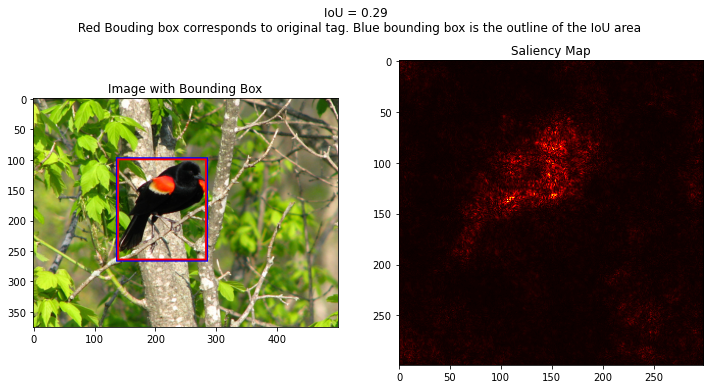

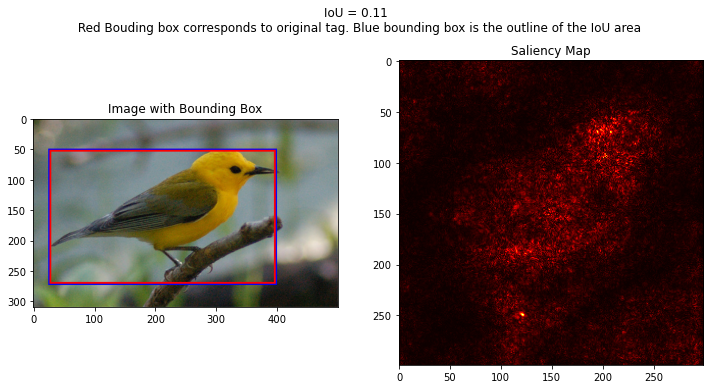

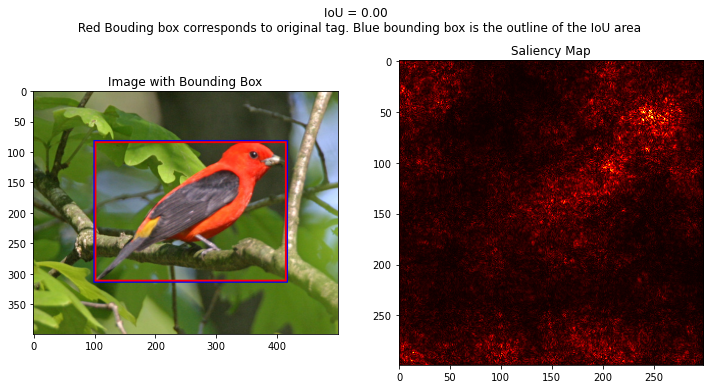

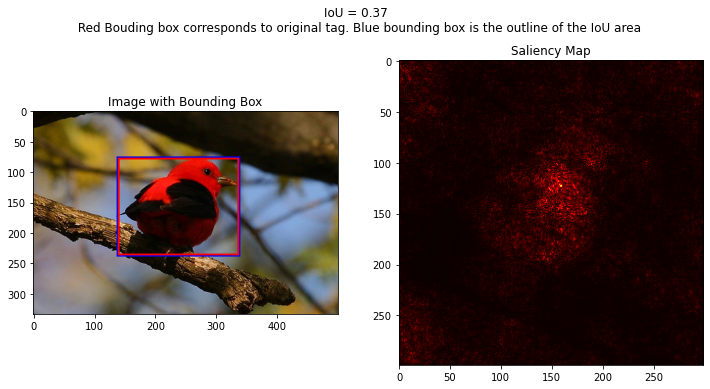

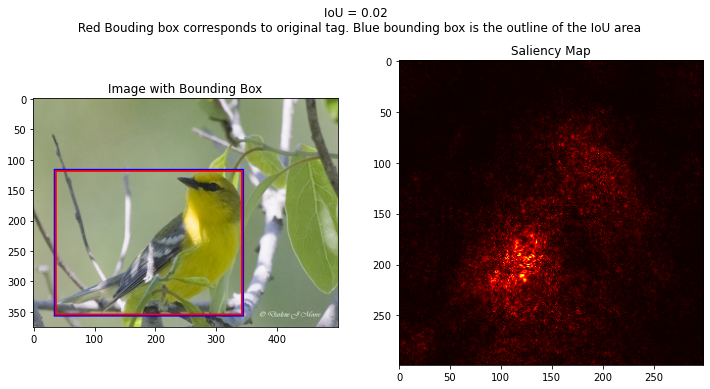

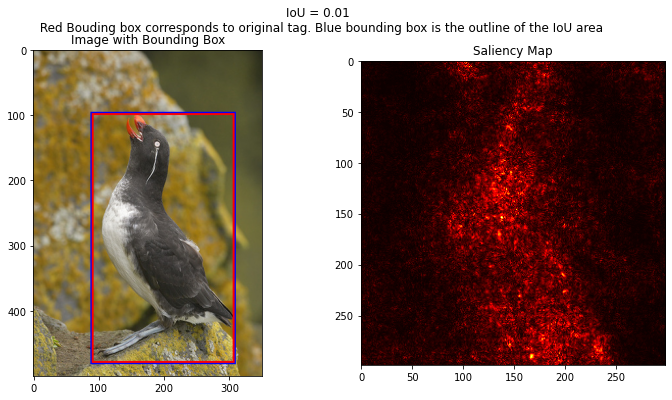

In [132]:
def plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_maps, iou_values):
    
    # Load saliency maps 
    saliency_maps = np.load(PATH_saliency_maps)
        
    for i in range(len(test_image_df)):
        
        # Load the image
        image = Image.open(test_image_df['full_path'][i])
        
        # Saliency maps
        saliency_map = saliency_map = saliency_maps[:,:,i]

        # Create a draw object
        draw = ImageDraw.Draw(image)
        bounding_box = test_image_df['bounding_box'][i]
        bounding_box = list(map(int,bounding_box))

        # Draw the bounding box on the image
        draw.rectangle(bounding_box, outline='red', width=5)


        # Draw a rectangle to highlight the intersection area
        draw.rectangle(bounding_box, outline='blue', width=2, fill=None)
        draw.rectangle(bounding_box, outline='blue', width=2)

        plt.figure(figsize=(12, 6))
        # Plot the image with the bounding box and saliency map
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image with Bounding Box')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title('Saliency Map')

        # Add a text label for the IoU
        plt.suptitle(f'IoU = {iou_values[i]:.2f} \n Red Bouding box corresponds to original tag. Blue bounding box is the outline of the IoU area')

        plt.show()

plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_map, iou_values)

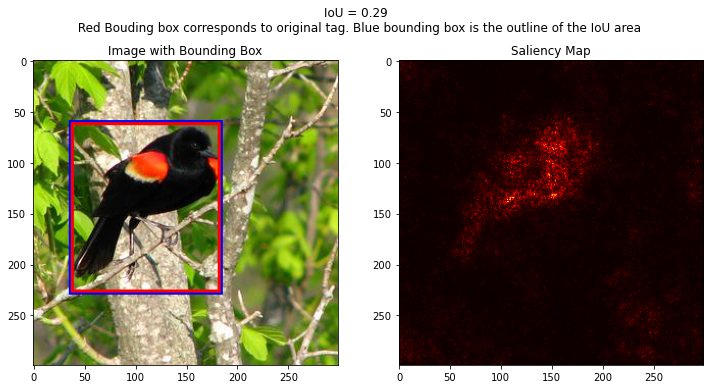

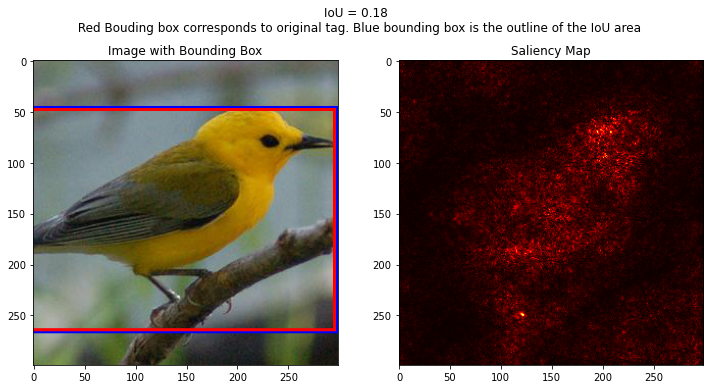

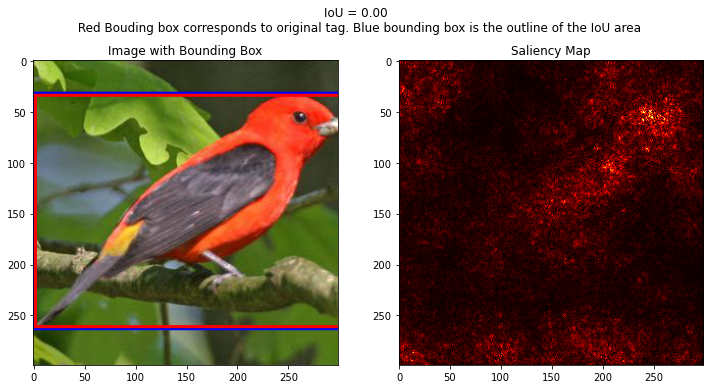

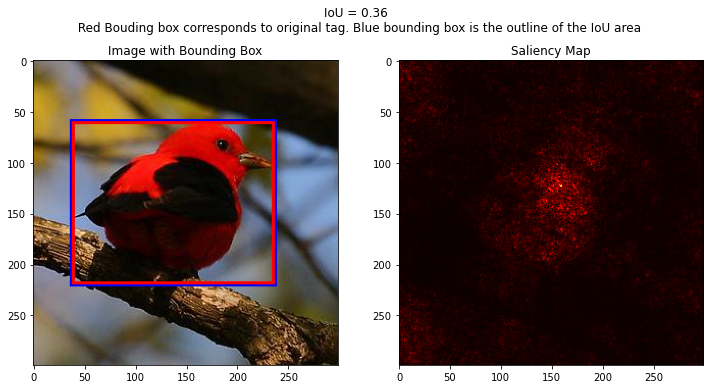

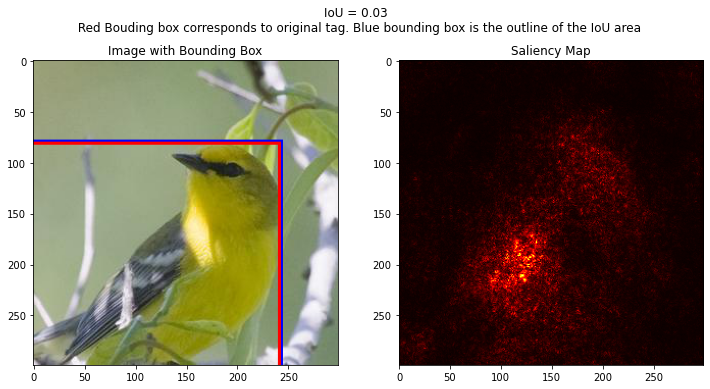

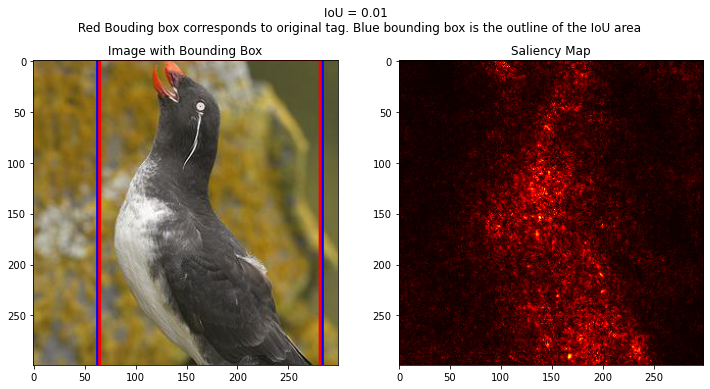

In [139]:
def plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_maps, iou_values):
    # Load saliency maps
    saliency_maps = np.load(PATH_saliency_maps)
    
    for i in range(len(test_image_df)):
        # Load the image
        image = Image.open(test_image_df['cropped_image_path'][i])
        
        # Saliency maps
        saliency_map = saliency_maps[:,:,i]

        # Create a draw object
        draw = ImageDraw.Draw(image)
        bounding_box = test_image_df['new_bbox'][i]
        bounding_box = list(map(int, bounding_box))

        # Draw the bounding box on the image
        draw.rectangle(bounding_box, outline='red', width=5)

        # Draw a rectangle to highlight the intersection area
        draw.rectangle(bounding_box, outline='blue', width=2, fill=None)
        draw.rectangle(bounding_box, outline='blue', width=2)

        plt.figure(figsize=(12, 6))
        # Plot the image with the bounding box and saliency map
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image with Bounding Box')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title('Saliency Map')

        # Add a text label for the IoU
        plt.suptitle(f'IoU = {iou_values[i]:.2f} \n Red Bouding box corresponds to original tag. Blue bounding box is the outline of the IoU area')

        plt.show()
        

plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_map, iou_values)


> Part names, locations and if they are visible

In [96]:
# Load the parts data
parts_df = pd.read_csv('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/parts/part_locs.txt', sep=' ', header=None, names=['image_id', 'part_id', 'x', 'y', 'visible'])

# Load the part names
with open('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/parts/parts.txt', 'r') as f:
    part_names = {int(line.split()[0]): line.split()[1] for line in f.readlines()}

# Merge the parts data with test_image_df
test_image_df = test_image_df.merge(parts_df, left_on='id', right_on='image_id',how='left')

# Add the part name column
test_image_df['part_name'] = test_image_df['part_id'].map(part_names)

# Add the part_location column
test_image_df['part_location'] = list(zip(test_image_df['x'], test_image_df['y']))

In [97]:
test_image_df.head()

id                                          file_path  \
0  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
1  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
2  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
3  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
4  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   
1  /Users/lucialarraona/Desktop/responsibleai/Con...   
2  /Users/lucialarraona/Desktop/responsibleai/Con...   
3  /Users/lucialarraona/Desktop/responsibleai/Con...   
4  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   
1  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   
2  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   
3  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   
4  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   

                                  cropped_image_path  \
0  /Users/lucialarraona/XAI_project/cropped_image...   
1  /Users/lucialarraona/XAI_project/cropped_image...   
2  /Users/lucialarraona/XAI_project/cropped_image...   
3  /Users/lucialarraona/XAI_project/cropped_image...   
4  /Users/lucialarraona/XAI_project/cropped_image...   

                     new_bbox  image_id  part_id      x      y  visible  \
0  (35.5, 59.0, 185.5, 229.0)       508        1  222.0  119.0        1   
1  (35.5, 59.0, 185.5, 229.0)       508        2  275.0  130.0        1   
2  (35.5, 59.0, 185.5, 229.0)       508        3  238.0  176.0        1   
3  (35.5, 59.0, 185.5, 229.0)       508        4  251.0  159.0        1   
4  (35.5, 59.0, 185.5, 229.0)       508        5  257.0  107.0        1   

  part_name   part_location  
0      back  (222.0, 119.0)  
1      beak  (275.0, 130.0)  
2     belly  (238.0, 176.0)  
3    breast  (251.0, 159.0)  
4     crown  (257.0, 107.0)

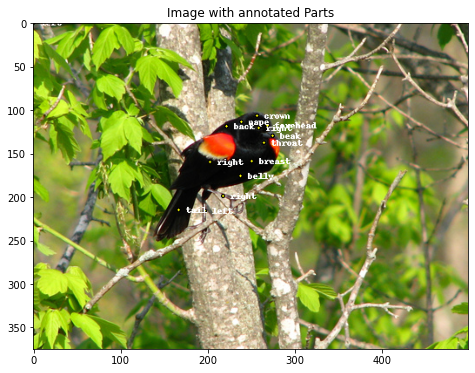

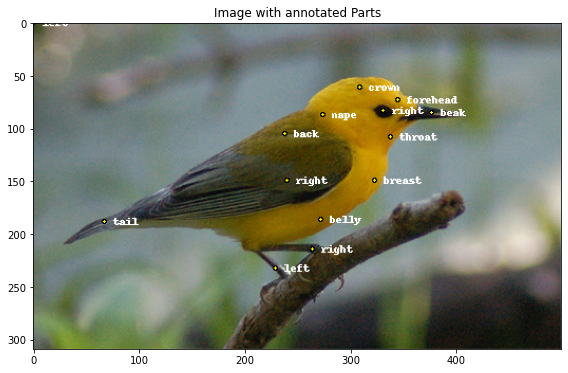

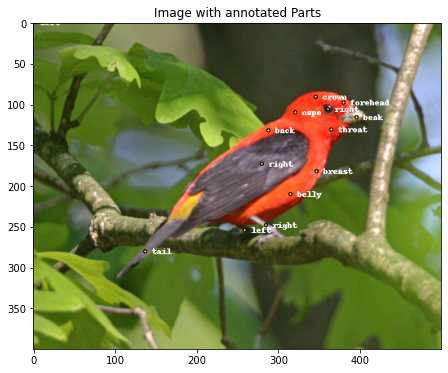

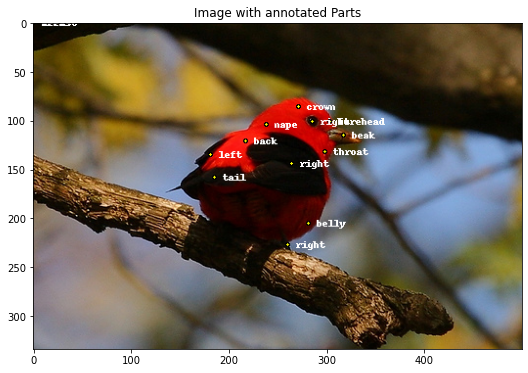

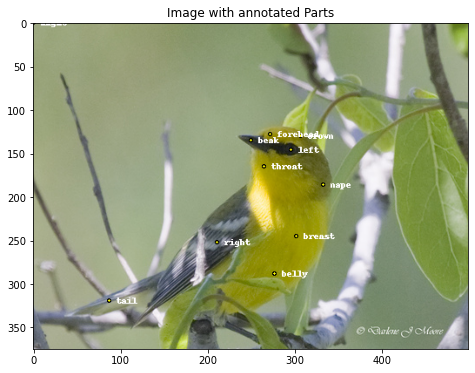

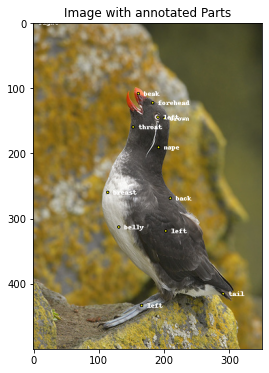

In [98]:
image_ids = list(test_image_df['id'].unique())

for image_id in image_ids:

    # Load the image
    image = Image.open(test_image_df[test_image_df['id'] == image_id]['full_path'].values[0])

    # Load the bounding box
    x1, y1, x2, y2 = test_image_df[test_image_df['id'] == image_id]['bounding_box'].values[0]

    # Calculate the coordinates of the top-left corner of the cropped image
    left = x1
    top = y1

    # Load the part locations for this image
    part_locations = test_image_df[test_image_df['id'] == image_id][['part_name', 'part_location']]
    # Relocate the part locations based on the cropped image
    #part_locations['new_part_location'] = part_locations['part_location'].apply(lambda x: tuple(b - a for a, b in zip(x, (left, top))))

    # Draw circles around the relocated part locations on the cropped image
    draw = ImageDraw.Draw(image)
    for i in range(len(part_locations)):
        x, y = part_locations.iloc[i]['part_location']
        draw.ellipse([x-2, y-2, x+2, y+2], fill='yellow', outline='black')
        draw.text([x+9, y-5], part_locations.iloc[i]['part_name'], fill='white')


    # Display the cropped image with the relocated part locations
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.title('Image with annotated Parts')
    plt.show()

- **Checking if the part location fall within the saliency map bounds:**

    *This code checks whether the x and y coordinates of each part location are within the bounds of the saliency map, and increments the count if they are. Note that we check that x is between 0 and the width of the saliency map (which is the second element of saliency_map_shape), and that y is between 0 and the height of the saliency map (which is the first element of saliency_map_shape).*

In [100]:
saliency_map_shape = saliency_maps[:,:,0].shape
num_part_locations_within_saliency_map = 0
for location in part_locations['part_location']:
    x, y = location
    if x >= 0 and x < saliency_map_shape[1] and y >= 0 and y < saliency_map_shape[0]:
        num_part_locations_within_saliency_map += 1


NameError: name 'saliency_maps' is not defined

- **Checkin if the part locations are not only within the saliency map bounds, but also if they are close to the most salient pixels**

*In this example, we load the saliency map and part locations. We then find the location of the most salient pixel(s) in the saliency map by using the np.argwhere function to get the indices of the maximum values in the saliency map, and then calculate the mean location of these indices. We then calculate the distance between each part location and the most salient pixel(s) using the np.linalg.norm function, and finally check which part locations are close enough to the most salient pixel(s) by using a threshold distance. The result is a list of part locations that are close enough to the most salient pixel(s).*

In [ ]:
# Load the saliency map and part locations
saliency_map = Image.open("saliency_map.png")
part_locations = [(10, 20), (30, 40), (50, 60)]  # Example part locations

# Find the location of the most salient pixel(s) in the saliency map
most_salient_pixels = np.argwhere(saliency_map == np.max(saliency_map))
most_salient_pixels_mean = np.mean(most_salient_pixels, axis=0)  # Calculate the mean location of the most salient pixels

# Calculate the distance between each part location and the most salient pixel(s)
distances = [np.linalg.norm(np.array(part_loc) - most_salient_pixels_mean) for part_loc in part_locations]

# Set a threshold distance to determine if a part location is close enough to the most salient pixel(s)
threshold_distance = 50  # Example threshold distance

# Check which part locations are close enough to the most salient pixel(s)
close_part_locations = [part_loc for part_loc, dist in zip(part_locations, distances) if dist < threshold_distance]


In [ ]:
######## UPDATED TO TRY TO GIVE A PERCENTAGE of close part locations ######

import numpy as np

# Set the threshold distance for a part location to be considered close to the most salient pixel
threshold = 30

# Load the saliency map
saliency_map = np.load('saliency_map.npy')

# Get the indices of the highest values in the saliency map
most_salient_pixels = np.argwhere(saliency_map == np.max(saliency_map))

# Load the part locations
part_locations = np.load('part_locations.npy')

# Calculate the Euclidean distance between each part location and the most salient pixel
distances = np.linalg.norm(part_locations - most_salient_pixels, axis=1)

# Count the number of part locations that are close to the most salient pixel
num_close_part_locations = np.sum(distances < threshold)

# Calculate the percentage of part locations that are close to the most salient pixel
percent_close_part_locations = (num_close_part_locations / len(part_locations)) * 100

print(f"{percent_close_part_locations:.2f}% of part locations are close to the most salient pixel.")


#### Same but with the gradcam

In [114]:
def calculate_intersection_area_gradcam(PATH_gradcam_map, df, PATH_image_file, threshold=0.5):
    # Load the GradCAM map
    gradcam_maps = np.load(PATH_gradcam_map)
    gradcam_map = gradcam_maps[:,:,0]
    
    # Find the row in the dataframe that corresponds to the input image file
    folder_name = os.path.dirname(PATH_image_file)
    folder_id = folder_name.split('/')[-1]
    bird_class = int(folder_id.split('.')[0].lstrip('0'))
    bounding_box = df.loc[df['index'] == bird_class, ['x1', 'y1', 'x2', 'y2']].values[0]
    
    # Extract the bounding box coordinates from the row
    x1, y1, x2, y2 = map(int, bounding_box)

    # Threshold the GradCAM map to create a binary mask
    mask = (gradcam_map > threshold).astype(int)

    # Calculate the intersection between the binary mask and the bounding box
    intersection = mask[y1:y2, x1:x2] * (gradcam_map[y1:y2, x1:x2] > 0)
    iou_gradcam = np.sum(intersection) / (np.sum(mask[y1:y2, x1:x2]) + np.sum(gradcam_map[y1:y2, x1:x2] > 0) - np.sum(intersection))

    print(f'The value of the IoU gradcam is {iou_gradcam} for the image \n {PATH_image_file}')
    
    return iou_gradcam


iou_gradcam = calculate_intersection_area_gradcam(PATH_gradcam_map,df,PATH_image_file, threshold=0.09)

The value of the IoU gradcam is 1.0 for the image 
 /Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images/010.Red_winged_Blackbird/Red_Winged_Blackbird_0053_4072.jpg


IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 375

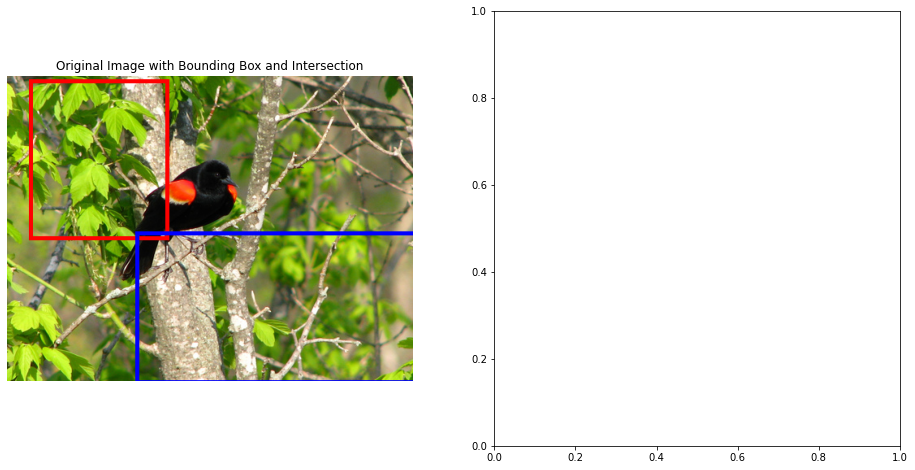

In [130]:
def plot_image_with_bbox_and_gradcam_map(image_path, bounding_box, gradcam_map, iou):
    # Load the image
    image = Image.open(image_path)

    # Create a draw object
    draw = ImageDraw.Draw(image)

    # Draw the original bounding box on the image
    bounding_box = list(map(int, bounding_box))
    draw.rectangle(bounding_box, outline='red', width=5)

    # Extract the bounding box coordinates
    x1, y1, x2, y2 = map(int, bounding_box)

    # Extract the region from the GradCAM map corresponding to the bounding box
    region = gradcam_map[y1:y2, x1:x2]

    # Threshold the region to create a binary mask
    threshold = np.mean(region) + np.std(region)
    mask = (region > threshold).astype(int)


    # Calculate the intersection between the binary masks
    intersection = (mask * np.array(image.convert('L'))) > 0


    # Draw the intersection bounding box on the image
    bbox_intersection = (x1 + np.min(np.where(np.sum(intersection, axis=0) > 0)),
                         y1 + np.min(np.where(np.sum(intersection, axis=1) > 0)),
                         x1 + np.max(np.where(np.sum(intersection, axis=0) > 0)),
                         y1 + np.max(np.where(np.sum(intersection, axis=1) > 0)))
    draw.rectangle(bbox_intersection, outline='blue', width=5)

    # Plot the image with the bounding boxes
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(image)
    ax[0].set_title('Original Image with Bounding Box and Intersection')
    ax[0].axis('off')

    # Draw the original and intersection bounding boxes on the GradCAM map
    gradcam_map_bbox = np.zeros_like(gradcam_map)
    gradcam_map_bbox[y1:y2, x1:x2] = gradcam_map[y1:y2, x1:x2]
    gradcam_map_bbox[intersection > 0] = 1
    ax[1].imshow(image.convert('L'), cmap='gray')
    ax[1].imshow(gradcam_map_bbox, alpha=0.5, cmap='hot')
    ax[1].set_title('GradCAM Map with Bounding Boxes')
    ax[1].axis('off')

    # Add a text label for the IoU
    fig.suptitle(f'IoU with GradCAM = {iou:.2f}', fontsize=16)

    plt.show()

plot_image_with_bbox_and_gradcam_map(PATH_image_file, bounding_box, gradcam_map,iou_gradcam)

### Concepts vs attributes

In a bottleneck model, the attributes are represented by a low-dimensional feature vector, which is typically much smaller than the input image or object feature vector. This feature vector captures the most important information about the object, and it can be used to recognize or classify the object.

The concepts in a bottleneck model are usually represented by the classes in the final output layer. Each class corresponds to a different concept that the model is trained to recognize. For example, in an image classification model, the classes might correspond to different types of objects or scenes, such as "dog", "cat", "beach", "mountain", etc.

To relate the attributes to the concepts, you can train a classifier on top of the bottleneck features. The classifier can take the bottleneck features as input and output a probability distribution over the different classes. The classifier can be trained using supervised learning on a labeled dataset, where each image is labeled with the correct class. Once the classifier is trained, you can use it to predict the class of new images based on their bottleneck features.

To interpret the learned concepts, you can analyze the weights of the final output layer. Each weight corresponds to a different feature in the bottleneck representation, and the magnitude of the weight indicates how important that feature is for the corresponding class. You can visualize these weights as heatmaps to get an idea of which parts of the object or image are most important for different concepts.

## Comprehensibility of explanations provided by each model

This could be assessed through a user study where participants are presented with explanations generated by each model and are asked to rate them based on how understandable they are. We can also use metrics such as reading time or error rates to evaluate the effectiveness of the explanations.

# Comparing the sucess of the two models

To compare the success of the two models, we can conduct a randomized controlled trial where participants are randomly assigned to either the saliency map or concept bottleneck group. Each group would be presented with the same set of input-output pairs and the explanations generated by their respective models. We can then collect data on accuracy and comprehensibility and compare the results between the two groups using statistical tests such as t-tests or ANOVA.